# CNN - CIFAR10 - Data Augmentation

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

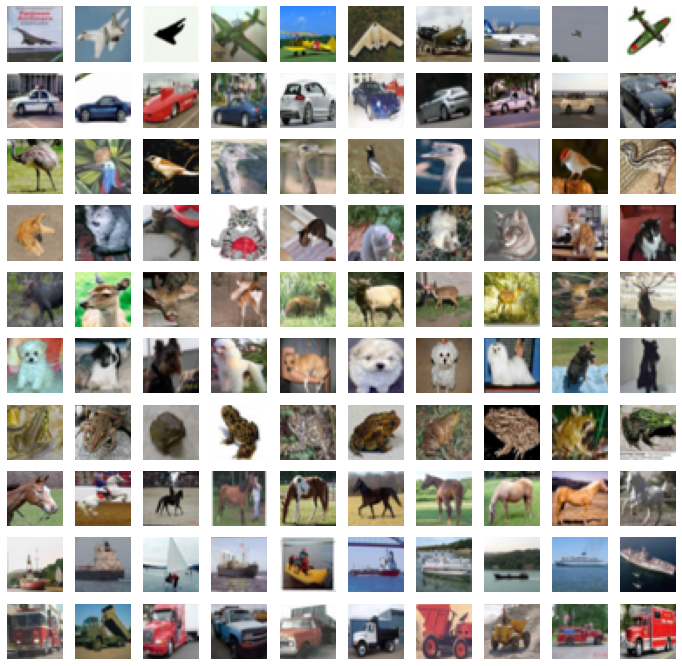

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [3]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [5]:
n_classes = 10
Y_train = utils.np_utils.to_categorical(y_train, n_classes)
Y_test = utils.np_utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

Define a CNN with the following structure : CONV(32F,same)-RELU-CONV(32F,same)-RELUMAXP(
2)-CONV(32F,same)-RELU-MAXP(2)-DENSE. Train the network using 10 epochs and batches
of 128 images. Use a categorical_crossentropy loss and the adam optimizer.

In [84]:
cnn = Sequential()
cnn.add(Conv2D(32,kernel_size=3,padding = "same",input_shape=(32,32,3)))
cnn.add(Activation("relu"))
cnn.add(Conv2D(32,kernel_size=3,padding = "same"))
cnn.add(Activation("relu"))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Conv2D(32,kernel_size=3,padding = "same"))
cnn.add(Activation("relu"))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(10,activation = "softmax"))
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                      

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [7]:
cnn.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
log = cnn.fit(X_train,Y_train,batch_size=256,epochs=10,validation_data=(X_test,Y_test))

Epoch 1/10
196/196 [==============================] - 6s 15ms/step - loss: 1.7054 - accuracy: 0.3866 - val_loss: 1.4308 - val_accuracy: 0.4904
Epoch 2/10
196/196 [==============================] - 3s 13ms/step - loss: 1.3255 - accuracy: 0.5298 - val_loss: 1.2509 - val_accuracy: 0.5549
Epoch 3/10
196/196 [==============================] - 3s 13ms/step - loss: 1.1908 - accuracy: 0.5842 - val_loss: 1.1774 - val_accuracy: 0.5845
Epoch 4/10
196/196 [==============================] - 3s 13ms/step - loss: 1.0955 - accuracy: 0.6177 - val_loss: 1.0834 - val_accuracy: 0.6201
Epoch 5/10
196/196 [==============================] - 3s 13ms/step - loss: 1.0137 - accuracy: 0.6486 - val_loss: 1.0230 - val_accuracy: 0.6459
Epoch 6/10
196/196 [==============================] - 3s 13ms/step - loss: 0.9532 - accuracy: 0.6722 - val_loss: 0.9686 - val_accuracy: 0.6673
Epoch 7/10
196/196 [==============================] - 3s 13ms/step - loss: 0.9075 - accuracy: 0.6870 - val_loss: 0.9399 - val_accuracy: 0.6736

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

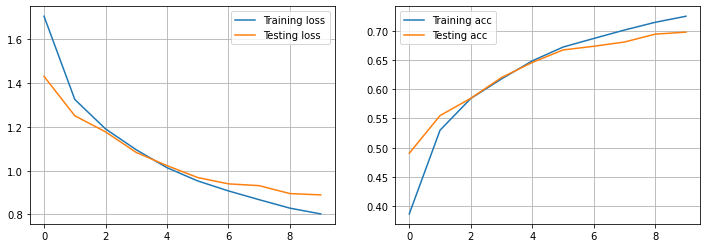

In [8]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [9]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)
loss_train, metric_train = cnn.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_train)

Test loss: 0.889529287815094
Test accuracy: 0.6977999806404114


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [10]:
pred = cnn.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

array([[804,  12,  34,  15,  11,   2,  13,   4,  67,  38],
       [ 27, 788,   7,   2,   4,   6,   9,   3,  34, 120],
       [113,   9, 544,  63,  88,  53,  74,  32,  15,   9],
       [ 45,  11,  76, 497,  69, 125, 103,  30,  28,  16],
       [ 40,   2,  81,  47, 662,  27,  69,  45,  18,   9],
       [ 32,   1,  65, 181,  59, 553,  39,  34,  21,  15],
       [ 10,   7,  54,  44,  40,  17, 813,   4,   5,   6],
       [ 46,   1,  33,  37,  72,  51,  12, 719,   5,  24],
       [111,  35,   8,   6,   5,   4,   8,   6, 790,  27],
       [ 52,  53,   9,  11,  11,   4,   6,   8,  38, 808]], dtype=int64)

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=8,width_shift_range=0.08,shear_range=0.3,height_shift_range=0.08,zoom_range=0.08)
batches = gen.flow(X_train,Y_train,batch_size=256)
valbatches = gen.flow(X_test,Y_test,batch_size=256)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

In [12]:
cnn.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
log = cnn.fit(batches,steps_per_epoch=50000//256,epochs=50,validation_data=valbatches,validation_steps=10000//256)

Epoch 1/50
195/195 [==============================] - 15s 76ms/step - loss: 0.9466 - accuracy: 0.6701 - val_loss: 1.0027 - val_accuracy: 0.6540
Epoch 2/50
195/195 [==============================] - 15s 74ms/step - loss: 0.9236 - accuracy: 0.6789 - val_loss: 0.9545 - val_accuracy: 0.6670
Epoch 3/50
195/195 [==============================] - 15s 74ms/step - loss: 0.9026 - accuracy: 0.6888 - val_loss: 0.9117 - val_accuracy: 0.6827
Epoch 4/50
195/195 [==============================] - 14s 74ms/step - loss: 0.8874 - accuracy: 0.6951 - val_loss: 0.9243 - val_accuracy: 0.6804
Epoch 5/50
195/195 [==============================] - 15s 74ms/step - loss: 0.8733 - accuracy: 0.6981 - val_loss: 0.9166 - val_accuracy: 0.6853
Epoch 6/50
195/195 [==============================] - 15s 75ms/step - loss: 0.8541 - accuracy: 0.7045 - val_loss: 0.9105 - val_accuracy: 0.6849
Epoch 7/50
195/195 [==============================] - 14s 72ms/step - loss: 0.8509 - accuracy: 0.7060 - val_loss: 0.8821 - val_accuracy:

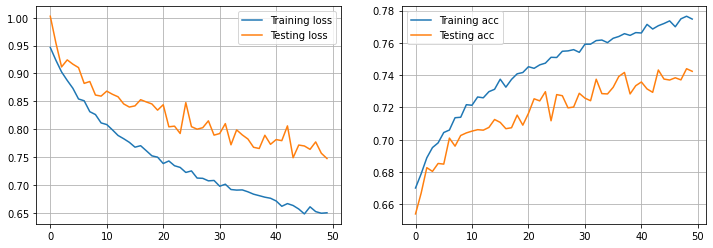

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [14]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)
loss_train, metric_train = cnn.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_train)

Test loss: 0.7610297799110413
Test accuracy: 0.7570000290870667


In [15]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=80,width_shift_range=0.8,shear_range=0.8,height_shift_range=0.8,zoom_range=0.8)
batches = gen.flow(X_train,Y_train,batch_size=256)
valbatches = gen.flow(X_test,Y_test,batch_size=256)

In [16]:
cnn.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
log = cnn.fit(batches,steps_per_epoch=50000//256,epochs=50,validation_data=valbatches,validation_steps=10000//256)

Epoch 1/50
195/195 [==============================] - 15s 78ms/step - loss: 2.0883 - accuracy: 0.2500 - val_loss: 1.9887 - val_accuracy: 0.2685
Epoch 2/50
195/195 [==============================] - 16s 81ms/step - loss: 1.9646 - accuracy: 0.2832 - val_loss: 1.9612 - val_accuracy: 0.2861
Epoch 3/50
195/195 [==============================] - 17s 85ms/step - loss: 1.9447 - accuracy: 0.2924 - val_loss: 1.9327 - val_accuracy: 0.2912
Epoch 4/50
195/195 [==============================] - 16s 81ms/step - loss: 1.9172 - accuracy: 0.3032 - val_loss: 1.9187 - val_accuracy: 0.3025
Epoch 5/50
195/195 [==============================] - 16s 81ms/step - loss: 1.9020 - accuracy: 0.3108 - val_loss: 1.8941 - val_accuracy: 0.3167
Epoch 6/50
195/195 [==============================] - 16s 81ms/step - loss: 1.8967 - accuracy: 0.3147 - val_loss: 1.8987 - val_accuracy: 0.3094
Epoch 7/50
195/195 [==============================] - 15s 79ms/step - loss: 1.8852 - accuracy: 0.3173 - val_loss: 1.8812 - val_accuracy:

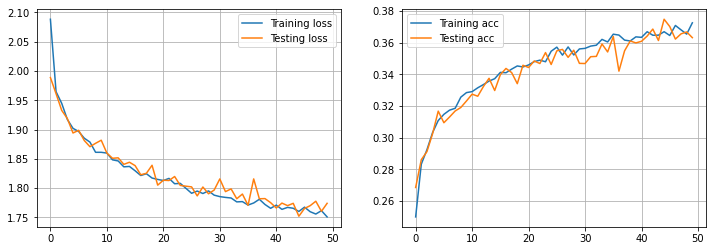

In [17]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [19]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)
loss_train, metric_train = cnn.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_train)

Test loss: 1.5003182888031006
Test accuracy: 0.4934999942779541
Test accuracy: 0.5039200186729431


### Table of results

Describe your data augmentation strategies here.

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 72.3  | 68.9 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 78.4  | 73.7 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 50.4  | 49.3 |
| ... | | | |

<font style="color:green"> <h1> Exercise 2 Visualisation of activations </h1></font>

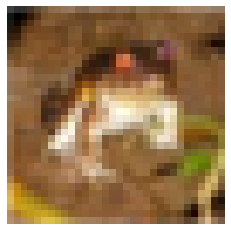

In [64]:
test_im1 = X_train[0]
plt.imshow(test_im1.reshape(32,32,3),interpolation='none')
plt.axis("off")
plt.show()

10


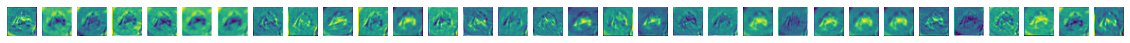

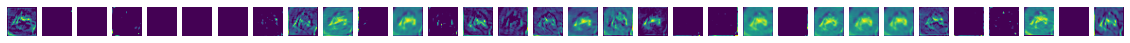

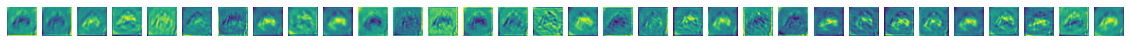

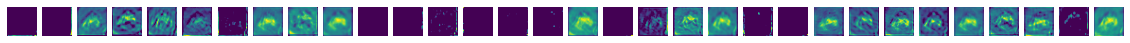

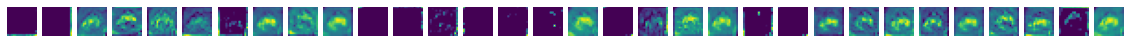

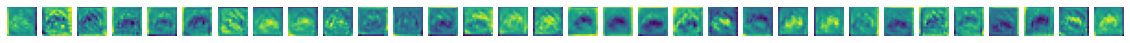

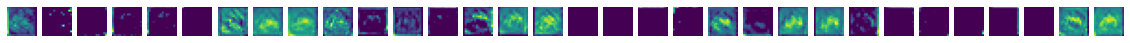

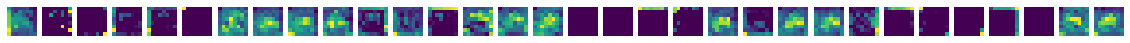

In [113]:
from keras import models
print(len(cnn.layers))
for j in range(8):
    layer_1st_conv = cnn.layers[j].output

    activation_model = models.Model(inputs=cnn.input,outputs=layer_1st_conv)


    test_im1 = test_im1.reshape(1,32,32,3)

    first_layer_activation = activation_model.predict(test_im1)

    fig = plt.figure(figsize=(20,20))
    for i in range(32):
        ax = fig.add_subplot(1,32,i+1)
        ax.imshow(first_layer_activation[0,:,:, i])
        ax.axis("off")


<font style="color:red"> it's the same sequence, as we created the network. The onces which are bright are CONV layers and the dark ones are activation and Maxpooling layers (in addition the maxpool layer got more and more pixelled becauce it's select the highest value...) </font>